In [4]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../bin/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


This notebook spawned from: http://localhost:5000/notebooks/Projects/hla_ii/data_analysis/patient_selection/helper_II.ipynb

### Set up analysis

Split patients

In [13]:
df = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/mhc_diversity/dataframe.csv',
                 index_col=0)
df = df.dropna()

In [14]:
df.homozygous_classI.value_counts()

0.0    4115
1.0    1007
2.0     247
3.0     129
Name: homozygous_classI, dtype: int64

In [15]:
df.classI_het.value_counts()

het      4115
other    1007
homo      376
Name: classI_het, dtype: int64

In [16]:
df.classII_cat.value_counts()

other    2966
low      1297
high     1235
Name: classII_cat, dtype: int64

In [17]:
df[df.classII_cat == 'low'].index

Index([u'TCGA-02-2470', u'TCGA-02-2483', u'TCGA-02-2485', u'TCGA-04-1346',
       u'TCGA-04-1362', u'TCGA-06-0130', u'TCGA-06-0141', u'TCGA-06-0168',
       u'TCGA-06-0173', u'TCGA-06-0189',
       ...
       u'TCGA-Z2-AA3V', u'TCGA-Z5-AAPL', u'TCGA-ZF-A9R0', u'TCGA-ZF-A9RN',
       u'TCGA-ZF-AA4U', u'TCGA-ZF-AA4X', u'TCGA-ZF-AA51', u'TCGA-ZF-AA5P',
       u'TCGA-ZP-A9D2', u'TCGA-ZS-A9CF'],
      dtype='object', length=1297)

Make data frames (affinities, mutations, tissuse)

In [19]:
class_label = 'class_i'
patient_affinities = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.{0}.csv'.format(class_label),
                                 index_col=0)
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv',
                                 index_col=0)

In [20]:
out = '/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/'

In [21]:
patient_affinities.ix[df[df.classI_cat == 'low'].index].to_csv(out + 'patient_affinities.{0}.low_i_cov.csv'.format(class_label))
patient_affinities.ix[df[df.classI_cat == 'high'].index].to_csv(out + 'patient_affinities.{0}.high_i_cov.csv'.format(class_label))

patient_mutations.ix[df[df.classI_cat == 'low'].index].to_csv(out + 'patient_mutations.{0}.low_i_cov.csv'.format(class_label))
patient_mutations.ix[df[df.classI_cat == 'high'].index].to_csv(out + 'patient_mutations.{0}.high_i_cov.csv'.format(class_label))

In [22]:
patient_affinities.ix[df[df.classI_het == 'homo'].index].to_csv(out + 'patient_affinities.{0}.i_homo.csv'.format(class_label))
patient_affinities.ix[df[df.classI_het == 'het'].index].to_csv(out + 'patient_affinities.{0}.i_het.csv'.format(class_label))

patient_mutations.ix[df[df.classI_het == 'homo'].index].to_csv(out + 'patient_mutations.{0}.i_homo.csv'.format(class_label))
patient_mutations.ix[df[df.classI_het == 'het'].index].to_csv(out + 'patient_mutations.{0}.i_het.csv'.format(class_label))

Run OR

In [27]:
def create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans):
    
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.helper.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        #out_file.write("#$ -t 1-4\n".format(len(thresholds)))
        out_file.write("#$ -t 1-{0}\n".format(len(thresholds)))
        out_file.write("#$ -l h_vmem=30G\n")
        out_file.write("#$ -tc 100\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set thresholds=({0})\n".format(" ".join(thresholds)))
        out_file.write("set models=({0})\n".format(" ".join(models)))
        out_file.write("set tissue_fs=({0})\n".format(" ".join(tissue_fs)))
        out_file.write("set mut_fs=({0})\n".format(" ".join(mut_fs)))
        out_file.write("set aff1_fs=({0})\n".format(" ".join(aff1_fs)))
        out_file.write("set aff2_fs=({0})\n".format(" ".join(aff2_fs)))
        out_file.write("set names=({0})\n".format(" ".join(names)))
        out_file.write("set pans=({0})\n".format(" ".join(pans)))
        out_file.write("\n")

        out_file.write("set threshold=$thresholds[$SGE_TASK_ID]\n")
        out_file.write("set model=$models[$SGE_TASK_ID]\n")
        out_file.write("set tissue_f=$tissue_fs[$SGE_TASK_ID]\n")
        out_file.write("set mut_f=$mut_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff1_f=$aff1_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff2_f=$aff2_fs[$SGE_TASK_ID]\n")
        out_file.write("set name=$names[$SGE_TASK_ID]\n")
        out_file.write("set pan=$pans[$SGE_TASK_ID]\n")
        out_file.write("\n")
        
        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")
  
        out_file.write("Rscript --vanilla /cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.R $threshold $model $tissue_f $mut_f $aff1_f $aff2_f $name $pan\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [31]:
# first MHC-II only (driver, passenger, germline); then both (driver, passenger, germline)
class_label = 'class_i'
models = ['0']*8
pans = ['1']*4
thresholds = ['2']*8
tissue_fs = ['patient_tissues.csv']*8
mut_fs = ['combined_classes/patient_mutations.{0}.low_i_cov.csv'.format(class_label),
           'combined_classes/patient_mutations.{0}.high_i_cov.csv'.format(class_label),
           'combined_classes/patient_mutations.{0}.i_homo.csv'.format(class_label),
           'combined_classes/patient_mutations.{0}.i_het.csv'.format(class_label)]*2
aff1_fs = ['combined_classes/patient_affinities.{0}.low_i_cov.csv'.format(class_label),
           'combined_classes/patient_affinities.{0}.high_i_cov.csv'.format(class_label),
           'combined_classes/patient_affinities.{0}.i_homo.csv'.format(class_label),
           'combined_classes/patient_affinities.{0}.i_het.csv'.format(class_label)]*2
# these are never referenced
aff2_fs = (['patient_affinities.cancer.all.csv', 'patient_affinities.passenger.csv', 
            'patient_affinities.germline.all.csv', 'combined_classes/patient_affinities.class_ii.csv', 
            'combined_classes/patient_affinities.passenger.class_ii.csv', 
            'combined_classes/patient_affinities.germline.class_ii.csv'])*2
names = ['{0}.low_i_cov'.format(class_label), 
         '{0}.high_i_cov'.format(class_label),
         '{0}.i_homo'.format(class_label),
         '{0}.i_het'.format(class_label)]*2

create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans)

### Results

Pan

In [65]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_0.class_i.ii_het.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.211847,1.184584,1.239738,1.577777e-61
patient,1.211847,1.184584,1.239738,1.577777e-61


In [66]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_0.class_i.ii_homo.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.184405,1.106395,1.267915,0.000001
patient,1.184405,1.106395,1.267915,0.000001


In [3]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_i.ii_het.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.220781,1.192344,1.249896,8.331345e-62
patient,1.220781,1.192344,1.249896,8.331345e-62


In [93]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_i.ii_homo.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.363103,1.240223,1.498159,1.305009e-10
patient,1.363103,1.240223,1.498159,1.305009e-10


Pan - class II

In [4]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.ii_het.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.224222,1.192723,1.256552,2.944859e-52
patient,1.224222,1.192723,1.256552,2.944859e-52


In [110]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.class_ii.ii_homo.txt',
           sep= ' ')

,OR,conf_OR_low,conf_OR_high,P
mutation,1.28935,1.150453,1.445017,0.000012
patient,1.28935,1.150453,1.445017,0.000012


Tissue

In [13]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_0.low_ii_cov.txt',
           sep= ',').sort_values('OR', ascending=False)

,OR,Lci,Hci,P
THCA,2.146184,1.725237,2.669840,7.085098e-12
LGG,1.464393,1.284892,1.668972,1.082669e-08
COAD,1.358520,1.355313,1.361735,0.000000e+00
PAAD,1.323129,1.045086,1.675145,1.999701e-02
READ,1.310537,0.961540,1.786205,8.694157e-02
OV,1.276041,0.968218,1.681730,8.350773e-02
SKCM,1.202931,1.066077,1.357352,2.714027e-03
GBM,1.175284,0.958076,1.441735,1.213347e-01
LUAD,1.143546,0.970958,1.346811,1.080707e-01
HNSC,1.098897,0.925539,1.304726,2.816465e-01


In [14]:
pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.tissue.thresh_0.high_ii_cov.txt',
           sep= ',').sort_values('OR', ascending=False)

,OR,Lci,Hci,P
PRAD,2.012736,0.934835,4.333502,7.381225e-02
THCA,2.003193,1.562034,2.568947,4.397989e-08
LGG,1.596613,1.404076,1.815553,9.587896e-13
COAD,1.398756,1.164197,1.680572,3.391116e-04
HNSC,1.289147,1.106636,1.501759,1.110415e-03
UCEC,1.271838,1.267742,1.275947,0.000000e+00
PAAD,1.213673,0.983263,1.498075,7.140914e-02
LIHC,1.207256,0.917391,1.588708,1.787820e-01
READ,1.163709,0.897797,1.508379,2.520166e-01
BLCA,1.139314,0.962879,1.348079,1.286763e-01


###Checking CD4 cell infiltration

In [5]:
infilatration = pd.read_csv('/cellar/users/ramarty/Data/Michelle/infiltration/tcga_tumor_infiltration.csv',
           index_col=0)

In [6]:
infilatration.head()

,Bcells,CAFs,CD4_Tcells,CD8_Tcells,Endothelial,Macrophages,NKcells,otherCells
TCGA-J2-8192,1.085420e-02,0.632929,0.151642,2.800826e-06,0.051002,0.041217,2.418213e-08,0.112353
TCGA-CJ-4885,1.378148e-02,0.016618,0.172775,7.091380e-02,0.249376,0.015379,1.736642e-10,0.461156
TCGA-AS-3777,1.791679e-07,0.019457,0.089918,1.803341e-04,0.093512,0.221128,2.478879e-04,0.575557
TCGA-80-5611,6.413054e-03,0.056618,0.056634,1.237215e-07,0.016106,0.086903,8.023214e-04,0.776524
TCGA-A8-A06R,3.027370e-02,0.388013,0.038336,2.228835e-03,0.063700,0.017226,3.472072e-06,0.460220


In [7]:
df.head()

,classI,classII,Tissue,Age,Race,homozygous_classI,homozygous_classII,homozygous_total,passenger_coverageI,passenger_coverageII,classI_cat,classII_cat,classI_het,classII_het
TCGA-02-0003,0.169941,0.073674,GBM,50.0,WHITE,0.0,1.0,1.0,0.169956,0.097588,other,other,het,het
TCGA-02-0033,0.184676,0.066798,GBM,54.0,WHITE,0.0,2.0,2.0,0.155702,0.094298,high,other,het,het
TCGA-02-0047,0.120825,0.085462,GBM,78.0,WHITE,2.0,1.0,3.0,0.164474,0.104167,low,high,homo,het
TCGA-02-0055,0.152259,0.066798,GBM,62.0,WHITE,0.0,2.0,2.0,0.166667,0.080044,low,other,het,het
TCGA-02-2466,0.181729,0.075639,GBM,61.0,WHITE,0.0,1.0,1.0,0.174342,0.093202,other,other,het,het


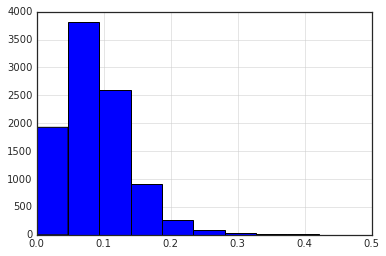

In [8]:
infilatration['CD4_Tcells'].hist()

In [9]:
df_both = pd.merge(df, infilatration, left_index=True, right_index=True)

In [11]:
df_both.homozygous_classII.value_counts()

1.0    1972
0.0    1405
2.0    1010
3.0     234
4.0     132
5.0      53
Name: homozygous_classII, dtype: int64

In [17]:
sp.mannwhitneyu(df_both[df_both.homozygous_classII > 3].CD4_Tcells,
                df_both[df_both.homozygous_classII < 1].CD4_Tcells)

MannwhitneyuResult(statistic=126271.0, pvalue=0.2647575286308349)

In [15]:
print df_both[df_both.homozygous_classII > 4].CD4_Tcells.mean()
print df_both[df_both.homozygous_classII < 1].CD4_Tcells.mean()

0.072945702559
0.088999166341


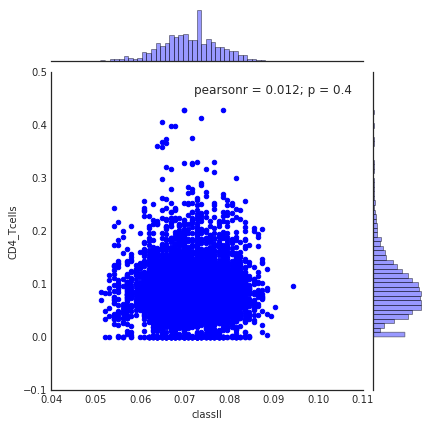

In [21]:
sns.jointplot(df_both.classII, df_both.CD4_Tcells)

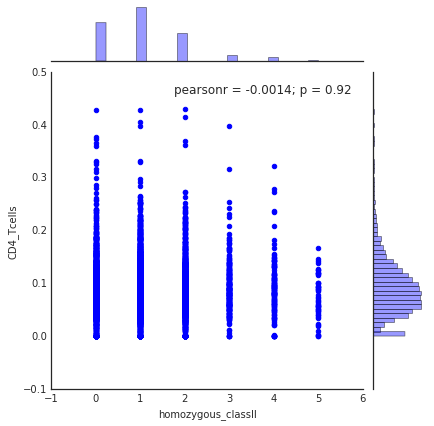

In [18]:
sns.jointplot(df_both.homozygous_classII, df_both.CD4_Tcells)

### Variation of small sample sizes

In [9]:
out = '/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/random/'

In [10]:
df[df.classII_het == 'homo'].index

Index([u'TCGA-02-2470', u'TCGA-02-2486', u'TCGA-04-1331', u'TCGA-06-0157',
       u'TCGA-06-0167', u'TCGA-06-0189', u'TCGA-06-0686', u'TCGA-06-0749',
       u'TCGA-06-0878', u'TCGA-06-5411',
       ...
       u'TCGA-XF-AAMR', u'TCGA-XF-AAN0', u'TCGA-XF-AAN5', u'TCGA-XV-A9W2',
       u'TCGA-Y8-A8RY', u'TCGA-YC-A9TC', u'TCGA-ZF-A9R2', u'TCGA-ZF-A9R7',
       u'TCGA-ZF-AA4X', u'TCGA-ZF-AA53'],
      dtype='object', length=498)

In [13]:
class_label = 'class_ii'
patient_affinities = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_affinities.{0}.csv'.format(class_label),
                                 index_col=0)
patient_mutations = pd.read_csv('/cellar/users/ramarty/Data/hla_ii/presentation/clean_matrices/combined_classes/patient_mutations.csv',
                                 index_col=0)

In [14]:
small_sample_size = len(df[df.classII_het == 'homo'].index)
print small_sample_size

498


In [54]:
for i in range(100):
    patient_samples = list(pd.Series(patient_affinities.index).sample(small_sample_size))
    patient_affinities.ix[patient_samples].to_csv(out + 'patient_affinities.{0}.small_sample_{1}.csv'.format(class_label, i))
    patient_mutations.ix[patient_samples].to_csv(out + 'patient_mutations.{0}.small_sample_{1}.csv'.format(class_label, i))

In [25]:
def create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans):
    
    new_script_file = '/cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.helper.random.sh'
    
    with open(new_script_file, 'w') as out_file:
        out_file.write("#! /bin/csh\n")
        out_file.write("#$ -V\n")
        out_file.write("#$ -S /bin/csh\n")
        out_file.write("#$ -o /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -e /cellar/users/ramarty/Data/hla_ii/sge-system_files\n")
        out_file.write("#$ -cwd\n")
        #out_file.write("#$ -t 1-2\n".format(len(thresholds)))
        out_file.write("#$ -t 1-{0}\n".format(len(thresholds)))
        out_file.write("#$ -l h_vmem=30G\n")
        out_file.write("#$ -tc 50\n")
        out_file.write("#$ -l long")
        out_file.write("\n")

        out_file.write("set thresholds=({0})\n".format(" ".join(thresholds)))
        out_file.write("set models=({0})\n".format(" ".join(models)))
        out_file.write("set tissue_fs=({0})\n".format(" ".join(tissue_fs)))
        out_file.write("set mut_fs=({0})\n".format(" ".join(mut_fs)))
        out_file.write("set aff1_fs=({0})\n".format(" ".join(aff1_fs)))
        out_file.write("set aff2_fs=({0})\n".format(" ".join(aff2_fs)))
        out_file.write("set names=({0})\n".format(" ".join(names)))
        out_file.write("set pans=({0})\n".format(" ".join(pans)))
        out_file.write("\n")

        out_file.write("set threshold=$thresholds[$SGE_TASK_ID]\n")
        out_file.write("set model=$models[$SGE_TASK_ID]\n")
        out_file.write("set tissue_f=$tissue_fs[$SGE_TASK_ID]\n")
        out_file.write("set mut_f=$mut_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff1_f=$aff1_fs[$SGE_TASK_ID]\n")
        out_file.write("set aff2_f=$aff2_fs[$SGE_TASK_ID]\n")
        out_file.write("set name=$names[$SGE_TASK_ID]\n")
        out_file.write("set pan=$pans[$SGE_TASK_ID]\n")
        out_file.write("\n")
        
        out_file.write("date\n")
        out_file.write("hostname\n")
        out_file.write("\n")
  
        out_file.write("Rscript --vanilla /cellar/users/ramarty/Projects/hla_ii/data_analysis/patient_selection/OR.R $threshold $model $tissue_f $mut_f $aff1_f $aff2_f $name $pan\n")
        out_file.write("\n")
                       
        out_file.write("date\n")

In [26]:
class_label = 'class_ii'
iterations = 100
models = ['0']*iterations
pans = ['1']*iterations
thresholds = ['0']*iterations
tissue_fs = ['patient_tissues.csv']*iterations
mut_fs = ['combined_classes/random/patient_mutations.{0}.small_sample_{1}.csv'.format(class_label, i) for i in range(100)]*iterations
aff1_fs = ['combined_classes/random/patient_affinities.{0}.small_sample_{1}.csv'.format(class_label, i) for i in range(100)]*iterations
aff2_fs = ['patient_affinities.cancer.all.csv']*iterations
names = ['random.{0}.{1}'.format(class_label, i) for i in range(100)]*iterations

create_cluster_script(thresholds, models, tissue_fs, mut_fs, aff1_fs, aff2_fs, names, pans)

Checking results

In [100]:
ORs = []
for i in range(100):
    try:
        ORs.append(pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_2.random.class_i.{0}.txt'.format(i),
               sep= ' ')['OR'][0])
    except:
        None

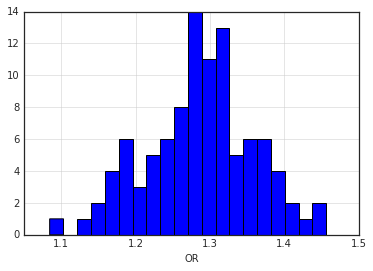

In [101]:
pd.Series(ORs).hist(bins=20)
plt.xlabel('OR')

In [55]:
ORs = []
for i in range(100):
    try:
        ORs.append(pd.read_csv('/cellar/users/ramarty/Data/hla_ii/generated_data/OR/MHC_II.pan.thresh_0.random.class_ii.{0}.txt'.format(i),
               sep= ' ')['OR'][0])
    except:
        None

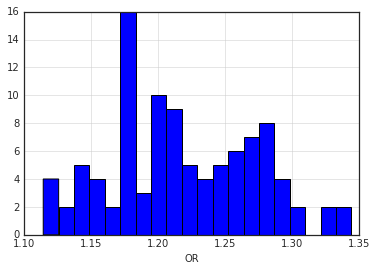

In [56]:
pd.Series(ORs).hist(bins=20)
plt.xlabel('OR')

In [57]:
len([x for x in ORs if x > 1.31]) / float(len(ORs))

0.04

In [58]:
len(ORs)

100